# <div class='bar_title'></div>

*Topics in Data Science 2*

# Image Classification with Deep Learning

Nikolai Steinl<br>
Chair of Information Systems and Business Analytics

Winter Semester 22/23

__Credits for this lecture__

<img src="https://images-na.ssl-images-amazon.com/images/I/516YvsJCS9L._SX379_BO1,204,203,200_.jpg" width="500" align="right"/>

**Jeremy Howard and Sylvian Gugger: "Deep Learning for Coders with Fastai and PyTorch: AI Applications without a PhD." (2020).**

Available as [Jupyter Notebook](https://github.com/fastai/fastbook) 

Materials taken from
- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://github.com/hiromis/notes/blob/master/Lesson1.md
- https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

## Processing Image Data

### Requirements

__Hardware: Graphics Processing Unit (GPU)__

GPU is fit for training the deep learning systems in a long run for very large datasets. CPU can train a deep learning model quite slowly. GPU accelerates the training of the model. Hence, GPU is a better choice to train the Deep Learning Model efficiently and effectively ([Medium](https://medium.com/@shachishah.ce/do-we-really-need-gpu-for-deep-learning-47042c02efe2)).

Make sure your GPU environment is set up and you can run Jupyter Notebook.

__GPU on [Google Colab](http://colab.research.google.com)__

* Select 'Runtime' -> 'Change runtime time' -> 'Python 3' (and 'GPU') before running the notebook.

__Libraries__

We are going to work with the fastai V2 library which sits on top of Pytorch.
The fastai library as a layered API as summarized by this graph:

<img src="https://docs.fast.ai/images/layered.png" width="500"/>

We need to install/upgrade fastai

In [ ]:
#!pip install git+https://github.com/fastai/fastai.git # we need the current git version

and import the library

In [3]:
from fastai.vision.all import *

### Dataset: Imagewoof

<img src="https://miro.medium.com/max/960/1*zZJpK1EXPU-gVyt46kNypQ.jpeg" width="500" align="right"/>


We are going to use the [Imagewoof](https://github.com/fastai/imagenette) data set, a subset of 10 classes from Imagenet that aren't so easy to classify, since they're all dog breeds. 

The breeds are: Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog. 

__Download and extract__

The first thing we have to do is download and extract the data that we want. `untar_data` will download that to some convenient path and untar it for us and it will then return the value of path.

In [4]:
# URLs.IMAGEWOOF_160 = 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-160'
path = untar_data(URLs.IMAGEWOOF_160); path

Path('/home/nist/.fastai/data/imagewoof2-160')

Next time you run this, since you've already downloaded it, it won't download it again. Since you've already untared it, it won't untar it again. So everything is designed to be pretty automatic and easy.

### Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

__Python 3 pathlib__

For convenience, fast.ai adds functionality into existing Python stuff. One of these things is add a `ls()` method to path.

In [5]:
path.ls()

(#3) [Path('/home/nist/.fastai/data/imagewoof2-160/val'),Path('/home/nist/.fastai/data/imagewoof2-160/noisy_imagewoof.csv'),Path('/home/nist/.fastai/data/imagewoof2-160/train')]

In [6]:
(path/'train').ls()

(#10) [Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02089973'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02111889'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02087394'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02105641'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02086240'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02096294'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02099601'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02088364'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02115641')]

Path objects from the [pathlib](https://docs.python.org/3/library/pathlib.html) module are much better to use than strings. It doesn't matter if you're on Windows, Linux, or Mac. It is always going to work exactly the same way.

__get_image_files__

`get_image_files` will just grab an array of all of the image files based on extension in a path.

In [7]:
fnames = get_image_files(path/'train')
fnames

(#9025) [Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_4354.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_3496.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_4629.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_1527.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_4796.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_3009.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_6445.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_6437.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_2984.JPEG'),Path('/home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_6659.JPEG')...]

Here, 'n02115641' refers to the class _dingo_ in [imagenet](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57).

In [36]:
#import imageio
#plt.imshow(imageio.imread(fnames[1]))

### Creating DataLoaders

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the names of the (sub-)folders. We will need to extract them to be able to classify the images into the correct categories. 

We will now explore different ways load these such datasets.

#### Factory Methods: ImageDataLoaders

The [`ImageDataLoaders`](https://docs.fast.ai/vision.data.html#ImageDataLoaders) Class is a basic wrapper around several DataLoaders with factory methods for computer vision problems.

Here, we can use `ImageDataLoaders.from_folder`:

In [8]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='val', item_tfms=Resize(224))

__data.show_batch__

Let's take a look at a few pictures. `dls.show_batch` can be used to show me some of the contents  So you can see roughly what's happened is that they all seem to have being zoomed and cropped in a reasonably nice way.

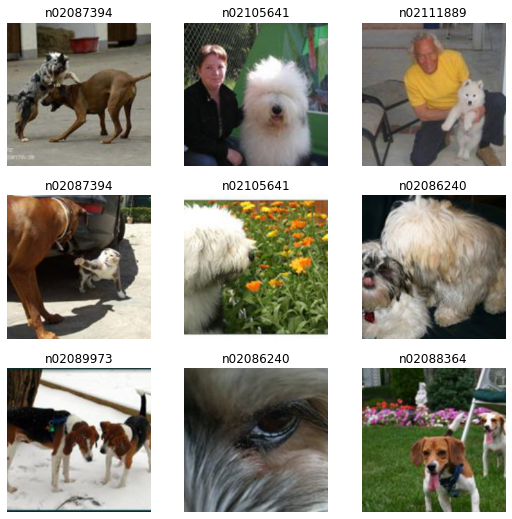

In [9]:
dls.show_batch()

### The data block API

The [data block API](https://docs.fast.ai/data.block.html#DataBlock) lets you customize the creation of the Dataloaders by isolating the underlying parts of that process in separate blocks, mainly:

1. The types of your input and labels
2. `get_items` (how to get your input)
3. `splitter` (How to split the data into a training and validation sets?)
4. `get_y` (How to label the inputs?)

... and suitable transforms. 

In [10]:
woof = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )

One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

These lines implement a fastai data augmentation strategy which we call *presizing*. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

#### Presizing

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/att_00060.png" align="right">

Presizing adopts two strategies

1. *Crop full width or height*: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.
2. *Random crop and augment*: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.

To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

#### Dataloaders

From the Datablock we can automatically get a our DataLoaders:

In [11]:
dls = woof.dataloaders(path)

.. and have a look at the summary:

In [12]:
woof.summary(path)

Setting-up type transforms pipelines
Found 12954 items
2 datasets of sizes 9025,3929
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_4354.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=213x160
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/nist/.fastai/data/imagewoof2-160/train/n02093754/n02093754_4354.JPEG
    applying parent_label gives
      n02093754
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=213x160, TensorCategory(4))


Found 12954 items
2 datasets of sizes 9025,3929
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'so

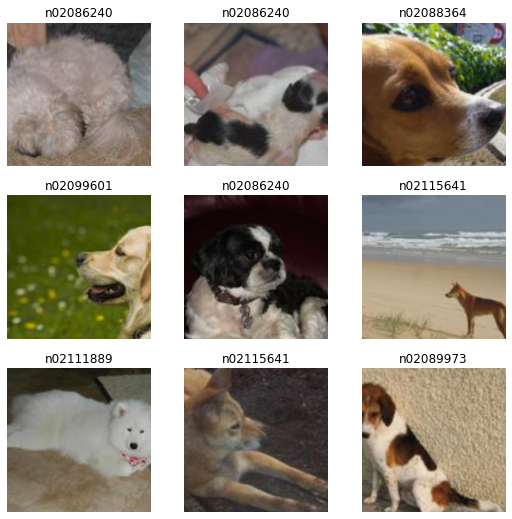

In [13]:
dls.show_batch()

To make the classes easier to read and interpret, we can modify our `get_y` function. First, we define a dictionary for the labels:

In [14]:
dogs_dict = { 'n02086240': 'Shih-Tzu',
              'n02087394': 'Rhodesian_ridgeback',
              'n02088364': 'beagle',
              'n02089973': 'English_foxhound',
              'n02093754': 'Border_terrier',
              'n02096294': 'Australian_terrier',
              'n02099601': 'golden_retriever',
              'n02105641': 'Old_English_sheepdog',
              'n02111889': 'Samoyed',
              'n02115641': 'dingo',
              }

And define our own `get_y`:

In [15]:
get_y = lambda x: dogs_dict[x.parent.name]

Now, we can create the `DataBlock` again

In [16]:
woof = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=get_y,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )

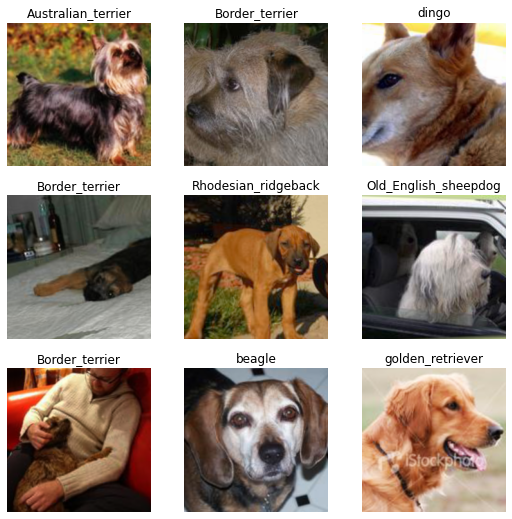

In [17]:
dls = woof.dataloaders(path)
dls.show_batch()

## Training

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. 

### The cnn_learner

This method creates a Learner object from the data object and model inferred from it with the backbone given in `arch`.

In [18]:
learn = vision_learner(dls=dls, arch=models.resnet34, metrics=accuracy)

/home/nist/.conda/envs/tds2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nist/.conda/envs/tds2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/nist/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- __dls__: Dataloaders
- __arch__: architecture. There are lots of different ways of constructing a convolutional neural network. For now, the most important thing for you to know is that there's a particular kind of model called ResNet which works extremely well nearly all the time. For a while, at least, you really only need to be doing choosing between two things which is what size ResNet do you want. There are ResNet34 and ResNet50. 
- __metrics__: accuracy
- __loss_func__: automatically inferred from `dls`. What kind of loss function would typically choose for this task?

Let's print a summary of the model.

In [19]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

__Resnet Architecture__

<img src="https://miro.medium.com/max/1314/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg" style="width:70%" />



### Find the learning rate

Please read the fast.ai [lr_finder docs](https://docs.fast.ai/callback.schedule#Learner.lr_find). Also, Sylvain Gugger from the fast.ai team wrote a nice [blog post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) on how to find  good learning rate.

SuggestedLRs(valley=0.0008317637839354575)

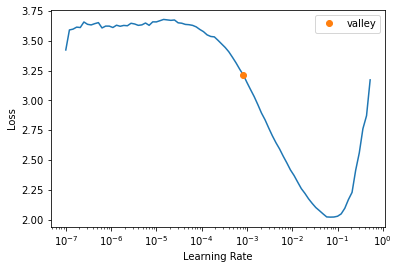

In [20]:
learn.lr_find()

### Fit the model

Fit the model based on selected learning rate

In [21]:
learn.fit_one_cycle(2, lr_max=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.581587,0.235460,0.927208,00:20
1,0.322900,0.223614,0.931026,00:20


In [22]:
learn.save('stage-1')

Path('models/stage-1.pth')

So far we have fitted 2 epochs and it ran pretty quickly. Why is that so? Because we used a little trick (called transfer learning).

What did we do?
We added a few extra layers at the end of architecture, and we only trained those. We left most of the early layers as they were. This is called freezing layers i.e weights of the layers.

- When we call fit or `fit_one_cycle()` on a create_cnn, it will just fine-tune these extra layers at the end, and run very fast.
- To get a better model, we have to call `unfreeze()` to train the whole model.

### Unfreeze and train again

Since our model is working as we expect it to, we will unfreeze our model and train some more.

In [23]:
learn.unfreeze()

SuggestedLRs(valley=1.4454397387453355e-05)

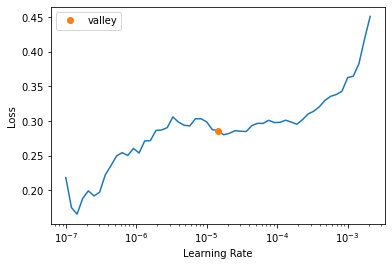

In [24]:
learn.lr_find()

__Learning rates after unfreezing__

The basic rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage.

In [25]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.286754,0.216652,0.935098,00:24
1,0.270390,0.217802,0.937389,00:23
2,0.255868,0.222424,0.936880,00:24
3,0.193436,0.211443,0.941461,00:25
4,0.169024,0.213148,0.938916,00:25
5,0.128801,0.212278,0.943752,00:26
6,0.120107,0.217351,0.941461,00:25
7,0.110982,0.219768,0.940188,00:25
8,0.098888,0.214586,0.940952,00:25
9,0.090552,0.210727,0.943497,00:25


If the model overfits we can reload stage 1 and train the model again for fewer epochs or another learning rate.

In [ ]:
learn = learn.load('stage-1')
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-5,1e-4))

## Results

It’s important to see what comes out of our model. We have seen one way of what goes in, now let’s see what our model has predicted.

The `ClassificationInterpretation` class has methods for creating confusion matrix as well as plotting misclassified images.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

### Top Losses

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not.

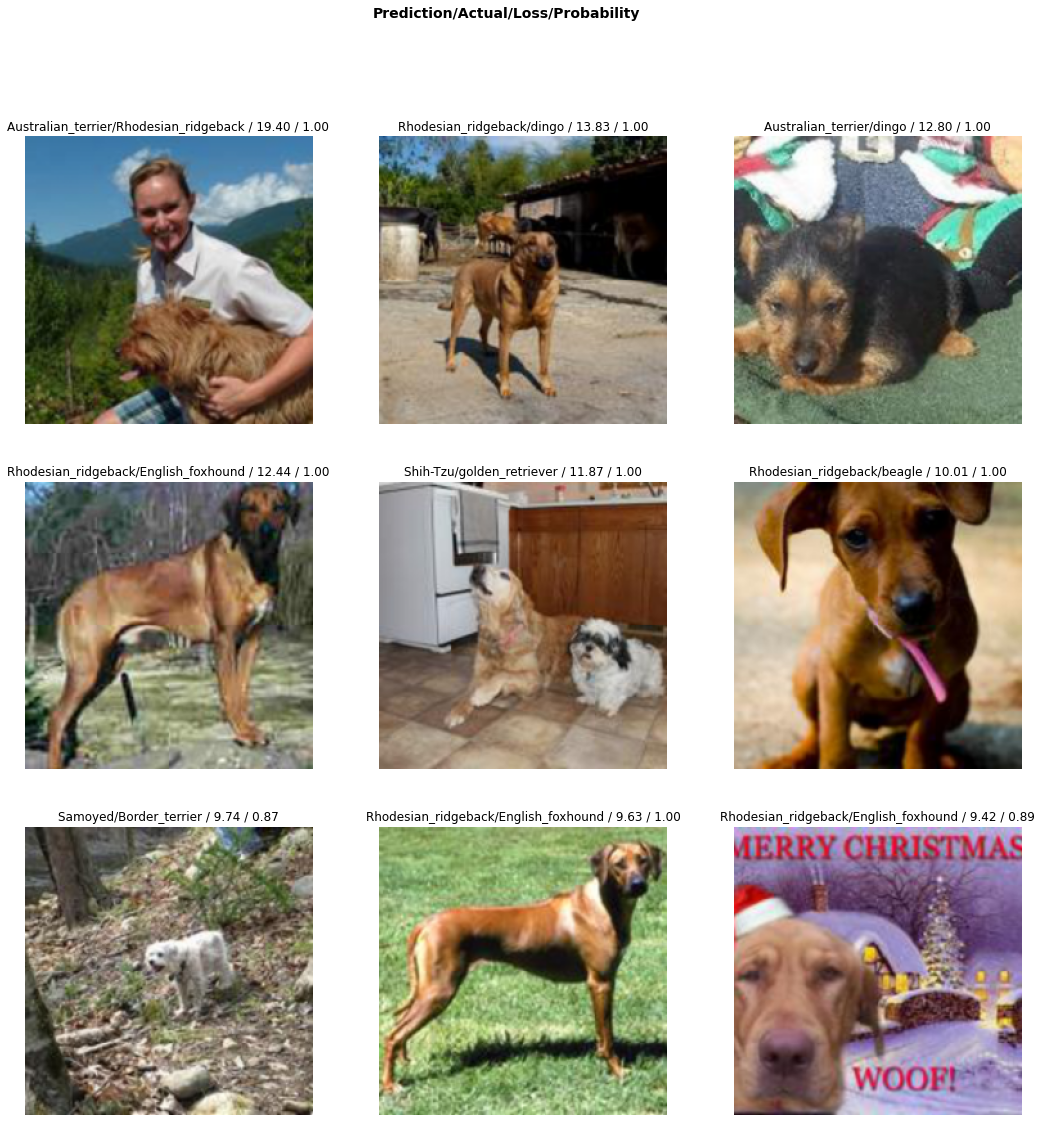

In [27]:
interp.plot_top_losses(9, largest=True, figsize=(18,18))

### Confusion Matrix

Furthermore, when we plot the confusion matrix. Interestingly, the model often confuses English Foxhounds with Beagles. This confirmes that our model works very well until a certain level as these two dog breeds look very similar.

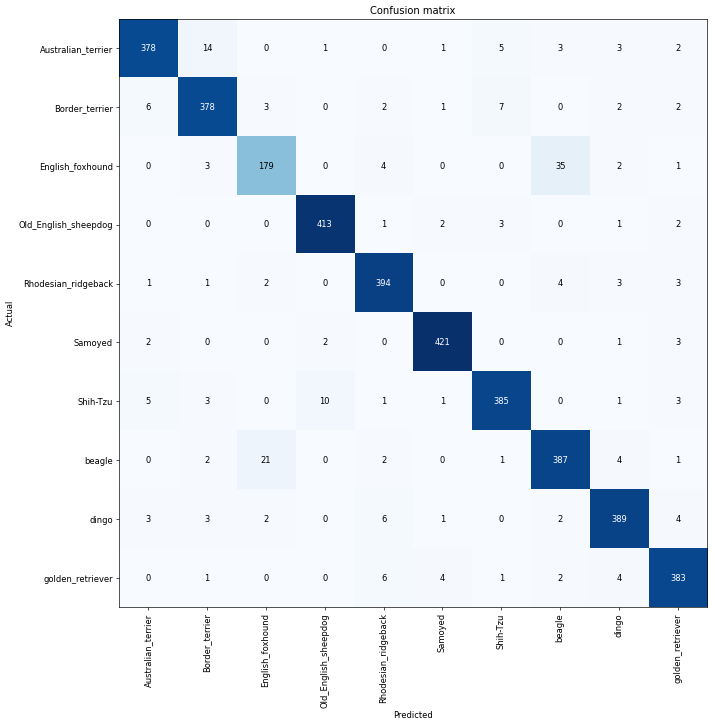

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

__Most Confused__

Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.

In [29]:
interp.most_confused(min_val=2)

[('English_foxhound', 'beagle', 35),
 ('beagle', 'English_foxhound', 21),
 ('Australian_terrier', 'Border_terrier', 14),
 ('Shih-Tzu', 'Old_English_sheepdog', 10),
 ('Border_terrier', 'Shih-Tzu', 7),
 ('Border_terrier', 'Australian_terrier', 6),
 ('dingo', 'Rhodesian_ridgeback', 6),
 ('golden_retriever', 'Rhodesian_ridgeback', 6),
 ('Australian_terrier', 'Shih-Tzu', 5),
 ('Shih-Tzu', 'Australian_terrier', 5),
 ('English_foxhound', 'Rhodesian_ridgeback', 4),
 ('Rhodesian_ridgeback', 'beagle', 4),
 ('beagle', 'dingo', 4),
 ('dingo', 'golden_retriever', 4),
 ('golden_retriever', 'Samoyed', 4),
 ('golden_retriever', 'dingo', 4),
 ('Australian_terrier', 'beagle', 3),
 ('Australian_terrier', 'dingo', 3),
 ('Border_terrier', 'English_foxhound', 3),
 ('English_foxhound', 'Border_terrier', 3),
 ('Old_English_sheepdog', 'Shih-Tzu', 3),
 ('Rhodesian_ridgeback', 'dingo', 3),
 ('Rhodesian_ridgeback', 'golden_retriever', 3),
 ('Samoyed', 'golden_retriever', 3),
 ('Shih-Tzu', 'Border_terrier', 3),
 (